In [1]:
# 05_team_vs_conference_averages.ipynb
# 📊 Team vs Conference Averages

# Requirements: pandas, matplotlib, seaborn (install via `pip install pandas matplotlib seaborn`)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("crest")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())


Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 🧭 What You'll Cover

> **Beginner tip:** Conference comparisons work best when you take notes on which teams exceed the league average. Treat this like a checklist you can revisit when scouting opponents.

Conference context helps explain whether gaudy team numbers are a product of league strength or true outperformance. In this notebook you will:
- confirm available seasons and pick one to analyze
- load team season summaries and derive tempo-free metrics
- compute conference averages and deltas for each team
- surface who is driving their league pace, offense, and defense
- visualize schedule-free over/under-performance with concise charts


In [2]:
# 📅 Discover available seasons
season_files = sorted(p.stem for p in (DATA_DIR / "team_season_stats").glob('*.csv'))
print(f"Available seasons ({len(season_files)}):")
print(', '.join(season_files[:10]))
if len(season_files) > 10:
    print('…')
    print(', '.join(season_files[-5:]))


Available seasons (21):
2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014
…
2021, 2022, 2023, 2024, 2025


## 🛠️ Set analysis parameters
Leave the defaults for a first pass, then plug in the conference you follow. Rerun the cell each time you make a change so the rest of the notebook picks it up.

Adjust the season, optional conference, and minimum games filter before rerunning.


In [3]:
# 🔁 Parameters
TARGET_SEASON = 2025  # swap to any available season above
TARGET_CONFERENCE = None  # e.g. 'Big Ten' to zoom in, or None for all
MIN_GAMES = 10  # hide tiny samples from the comparison

print(f"Analyzing season: {TARGET_SEASON}")
print(f"Conference filter: {TARGET_CONFERENCE or 'All conferences'}")
print(f"Minimum games required: {MIN_GAMES}")


Analyzing season: 2025
Conference filter: All conferences
Minimum games required: 10


## 📥 Load season data
This cell reads the CSVs and trims them to your filters. If you see fewer teams than expected, double-check the conference names in `teams.csv`.

Conference comparisons rely on the finalized team-level season tables packaged in this starter kit.


In [4]:
# 🗂️ Read team season stats
team_season_path = DATA_DIR / 'team_season_stats' / f'{TARGET_SEASON}.csv'
team_season = pd.read_csv(team_season_path)

# Drop non-D1 or exhibition rows that lack conference identifiers
team_season = team_season.dropna(subset=['conference']).copy()

if TARGET_CONFERENCE:
    team_season = team_season[team_season['conference'] == TARGET_CONFERENCE].copy()

print(f"Teams with conference data: {len(team_season):,}")
display(team_season[['team', 'conference', 'games', 'wins', 'teamStats_rating']].head())


Teams with conference data: 364


,team,conference,games,wins,teamStats_rating
0,Abilene Christian,WAC,32,16,103.80
1,Air Force,Mountain West,32,4,98.90
2,Akron,MAC,35,28,120.50
3,Alabama A&M,SWAC,32,10,114.70
4,Alabama,SEC,37,28,119.30


## 🔢 Derive tempo and efficiency metrics
We convert totals into rates so every team can be compared fairly. Watch how `net_rating` is calculated—it is the foundation for later visualizations.

Create a tidy table of team metrics that we can benchmark against conference peers.


In [5]:
# 📊 Build team metric frame
metric_frame = (
    team_season.assign(
        off_rating=lambda df: df['teamStats_rating'],
        def_rating=lambda df: df['opponentStats_rating'],
        net_rating=lambda df: df['teamStats_rating'] - df['opponentStats_rating'],
        off_efg=lambda df: df['teamStats_fourFactors_effectiveFieldGoalPct'],
        def_efg=lambda df: df['opponentStats_fourFactors_effectiveFieldGoalPct'],
        off_tov=lambda df: df['teamStats_fourFactors_turnoverRatio'],
        def_tov=lambda df: df['opponentStats_fourFactors_turnoverRatio'],
        off_orb=lambda df: df['teamStats_fourFactors_offensiveReboundPct'],
        def_orb=lambda df: df['opponentStats_fourFactors_offensiveReboundPct'],
        off_ftr=lambda df: df['teamStats_fourFactors_freeThrowRate'],
        def_ftr=lambda df: df['opponentStats_fourFactors_freeThrowRate'],
        true_shooting=lambda df: df['teamStats_trueShooting'],
    )
    [[
        'teamId', 'team', 'conference', 'games', 'wins', 'losses', 'pace',
        'off_rating', 'def_rating', 'net_rating', 'true_shooting',
        'off_efg', 'def_efg', 'off_tov', 'def_tov', 'off_orb', 'def_orb',
        'off_ftr', 'def_ftr'
    ]]
)

metric_frame = metric_frame.query('games >= @MIN_GAMES').reset_index(drop=True)

print(f"Teams after minimum games filter: {len(metric_frame)}")
display(metric_frame.head())


Teams after minimum games filter: 364


,teamId,team,conference,games,wins,losses,pace,off_rating,def_rating,net_rating,true_shooting,off_efg,def_efg,off_tov,def_tov,off_orb,def_orb,off_ftr,def_ftr
0,1,Abilene Christian,WAC,32,16,16,66.40,103.80,103.50,0.30,52.90,48.30,50.00,0.22,0.25,32.90,29.10,36.10,49.30
1,2,Air Force,Mountain West,32,4,28,61.10,98.90,117.90,-19.00,53.10,50.10,54.60,0.22,0.16,24.70,26.80,35.40,35.40
2,3,Akron,MAC,35,28,7,69.10,120.50,107.40,13.10,58.40,55.20,49.40,0.17,0.18,30.70,30.60,26.10,32.10
3,4,Alabama A&M,SWAC,32,10,22,61.50,114.70,124.50,-9.80,51.00,47.00,53.10,0.25,0.25,38.10,30.90,37.50,47.00
4,5,Alabama,SEC,37,28,9,74.50,119.30,106.90,12.40,60.30,56.60,47.80,0.17,0.14,29.30,33.90,39.30,33.20


## 🤝 Compare to conference averages
The resulting table shows how each team differs from its league. Positive numbers mean the team is outperforming the conference benchmark.

For every conference we compute the mean of each metric, then measure how far each team sits above or below that baseline.


In [6]:
# 🧮 Conference average join
compare_metrics = [
    'pace', 'off_rating', 'def_rating', 'net_rating', 'true_shooting',
    'off_efg', 'def_efg', 'off_tov', 'def_tov', 'off_orb', 'def_orb',
    'off_ftr', 'def_ftr'
]

conf_avgs = (
    metric_frame
    .groupby('conference')[compare_metrics]
    .mean()
    .add_suffix('_conf_avg')
    .reset_index()
)

team_vs_conf = metric_frame.merge(conf_avgs, on='conference', how='left')

for metric in compare_metrics:
    team_vs_conf[f'{metric}_delta'] = team_vs_conf[metric] - team_vs_conf[f'{metric}_conf_avg']

team_vs_conf = team_vs_conf.sort_values(['conference', 'net_rating_delta'], ascending=[True, False])

print('Team vs conference sample:')
display(team_vs_conf.head())


Team vs conference sample:


,teamId,team,conference,games,wins,losses,pace,off_rating,def_rating,net_rating,...,net_rating_delta,true_shooting_delta,off_efg_delta,def_efg_delta,off_tov_delta,def_tov_delta,off_orb_delta,def_orb_delta,off_ftr_delta,def_ftr_delta
332,333,VCU,A-10,35,28,7,63.80,119.40,97.30,22.10,...,17.81,1.50,1.47,-4.89,-0.00,0.03,5.65,2.85,-1.69,5.42
94,95,George Mason,A-10,36,27,9,62.80,108.40,96.80,11.60,...,7.31,1.60,0.97,-3.89,0.03,0.01,-1.25,3.85,8.51,-0.28
250,251,Saint Joseph's,A-10,35,22,13,65.00,113.10,103.40,9.70,...,5.41,0.70,0.47,-2.39,-0.00,-0.01,-0.55,-0.05,-2.09,-5.48
150,151,Loyola Chicago,A-10,37,26,11,65.30,109.80,102.10,7.70,...,3.41,1.10,2.17,-0.89,0.01,-0.00,-0.75,-0.55,-2.09,2.72
63,64,Dayton,A-10,34,23,11,61.90,117.80,110.20,7.60,...,3.31,2.60,2.07,1.51,-0.01,-0.00,-0.55,0.35,3.81,-0.68


## 🏅 Net rating movers
Sorting by the biggest gaps highlights surprise contenders or struggling favorites. Ask yourself whether each result matches what you have seen this season.

Spot which teams are pacing their league (or lagging) after adjusting for conference averages.


In [7]:
# 🔝 Top and bottom net rating deltas
net_cols = [
    'team', 'conference', 'games', 'wins', 'net_rating', 'net_rating_conf_avg', 'net_rating_delta'
]

net_leaders = team_vs_conf.sort_values('net_rating_delta', ascending=False).head(10)
net_trailers = team_vs_conf.sort_values('net_rating_delta').head(10)

print('Top 10 net rating vs conference average:')
display(net_leaders[net_cols])

print('Bottom 10 net rating vs conference average:')
display(net_trailers[net_cols])


Top 10 net rating vs conference average:


,team,conference,games,wins,net_rating,net_rating_conf_avg,net_rating_delta
71,Duke,ACC,39,35,31.30,3.68,27.62
309,UC San Diego,Big West,35,30,28.00,2.15,25.85
101,Gonzaga,WCC,35,26,23.90,3.45,20.45
161,McNeese,Southland,35,28,20.70,1.14,19.56
142,Lipscomb,ASUN,35,25,16.40,-1.83,18.23
273,Southern,SWAC,32,20,9.60,-8.47,18.07
332,VCU,A-10,35,28,22.10,4.29,17.81
112,Houston,Big 12,40,35,23.60,6.77,16.83
69,Drake,MVC,35,31,20.80,3.98,16.82
108,High Point,Big South,35,29,19.10,2.77,16.33


Bottom 10 net rating vs conference average:


,team,conference,games,wins,net_rating,net_rating_conf_avg,net_rating_delta
174,Mississippi Valley State,SWAC,31,3,-40.50,-8.47,-32.03
36,Cal State Fullerton,Big West,32,6,-21.10,2.15,-23.25
192,New Orleans,Southland,31,4,-21.60,1.14,-22.74
49,Chicago State,NEC,32,4,-24.20,-1.89,-22.31
1,Air Force,Mountain West,32,4,-19.00,2.88,-21.88
58,Coppin State,MEAC,30,6,-21.10,-0.74,-20.36
262,Seton Hall,Big East,32,7,-13.70,5.07,-18.77
41,Canisius,MAAC,31,3,-21.10,-2.51,-18.59
91,Fresno State,Mountain West,32,6,-15.60,2.88,-18.48
257,San Diego,WCC,33,6,-13.90,3.45,-17.35


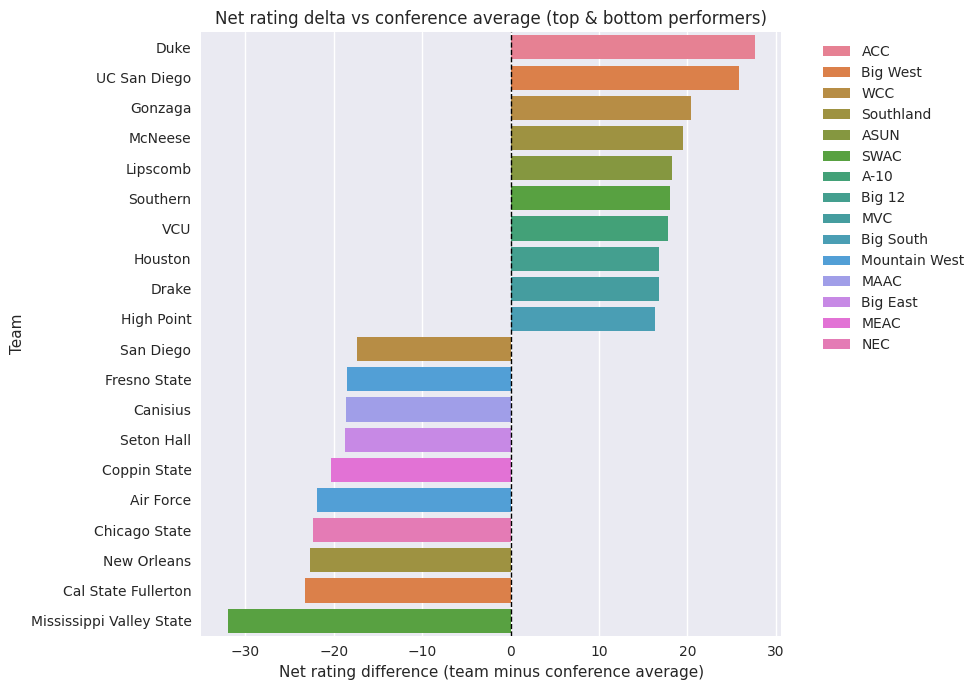

In [8]:
# 📈 Visualize net rating deltas
top_plot = pd.concat([net_leaders, net_trailers]).sort_values('net_rating_delta', ascending=False)

fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(
    data=top_plot,
    y='team',
    x='net_rating_delta',
    hue='conference',
    dodge=False,
    ax=ax
)
ax.axvline(0, color='black', linewidth=1, linestyle='--')
ax.set_title('Net rating delta vs conference average (top & bottom performers)')
ax.set_xlabel('Net rating difference (team minus conference average)')
ax.set_ylabel('Team')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 🔍 Multi-metric benchmarking
Plotting offense versus defense while color-coding pace helps explain *why* the gap exists. Spend time interpreting a few labeled points before moving on.

Heatmap the deltas across several tempo-free stats to see holistic over- or under-performance.


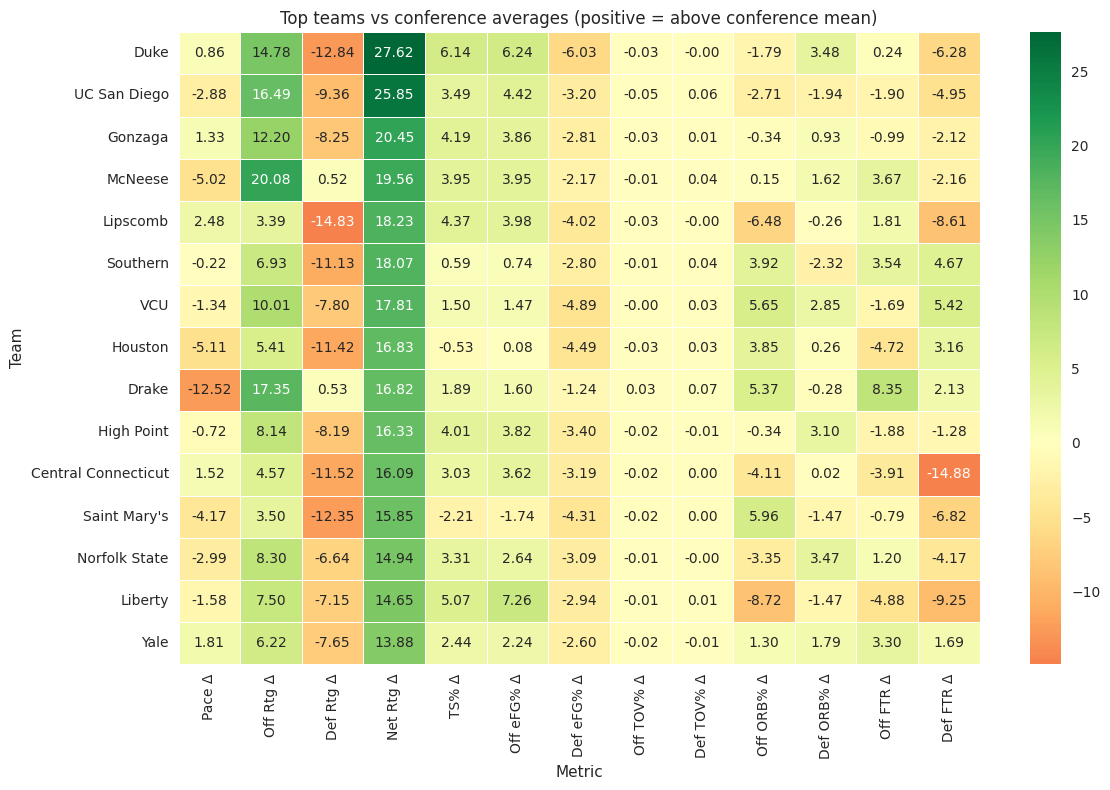

In [9]:
# 🌡️ Heatmap of conference deltas
delta_cols = {
    'pace_delta': 'Pace Δ',
    'off_rating_delta': 'Off Rtg Δ',
    'def_rating_delta': 'Def Rtg Δ',
    'net_rating_delta': 'Net Rtg Δ',
    'true_shooting_delta': 'TS% Δ',
    'off_efg_delta': 'Off eFG% Δ',
    'def_efg_delta': 'Def eFG% Δ',
    'off_tov_delta': 'Off TOV% Δ',
    'def_tov_delta': 'Def TOV% Δ',
    'off_orb_delta': 'Off ORB% Δ',
    'def_orb_delta': 'Def ORB% Δ',
    'off_ftr_delta': 'Off FTR Δ',
    'def_ftr_delta': 'Def FTR Δ'
}

heat_view = (
    team_vs_conf
    .sort_values('net_rating_delta', ascending=False)
    .head(15)
    .set_index('team')[list(delta_cols.keys())]
    .rename(columns=delta_cols)
)

plt.figure(figsize=(12, 8))
sns.heatmap(heat_view, cmap='RdYlGn', center=0, linewidths=0.5, annot=True, fmt='.2f')
plt.title('Top teams vs conference averages (positive = above conference mean)')
plt.xlabel('Metric')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


## 🏁 Conference roll-ups
This summary confirms whether your conference is unusually strong or weak overall. Compare the averages to national leaders to keep perspective.

Get a quick sense for the distribution of conference averages and which leagues drive national pace and efficiency.


In [10]:
# 🧾 Conference summary table
conference_summary = (
    conf_avgs
    .merge(
        metric_frame.groupby('conference')['teamId'].count().rename('teams'),
        on='conference',
        how='left'
    )
    .sort_values('net_rating_conf_avg', ascending=False)
)

cols_to_show = [
    'conference', 'teams', 'pace_conf_avg', 'off_rating_conf_avg',
    'def_rating_conf_avg', 'net_rating_conf_avg', 'true_shooting_conf_avg'
]

display(conference_summary[cols_to_show])


,conference,teams,pace_conf_avg,off_rating_conf_avg,def_rating_conf_avg,net_rating_conf_avg,true_shooting_conf_avg
23,SEC,16,66.67,116.81,106.90,9.91,57.03
9,Big Ten,18,66.16,113.84,106.42,7.42,56.74
5,Big 12,16,65.61,111.49,104.72,6.77,55.73
6,Big East,11,64.67,111.50,106.43,5.07,55.85
12,CUSA,10,65.38,110.30,105.35,4.95,55.03
0,A-10,15,65.14,109.39,105.10,4.29,55.00
18,MVC,12,63.23,113.55,109.57,3.98,56.91
1,ACC,18,64.84,111.92,108.24,3.68,55.76
25,SoCon,10,64.89,112.17,108.57,3.60,55.11
30,WCC,11,65.97,112.30,108.85,3.45,56.01


## ✅ Next steps
Record the notable outliers you discover—they are great candidates for deeper scouting in later notebooks.

- Export `team_vs_conf` as a CSV to share benchmarks with coaching staffs.
- Filter `TARGET_CONFERENCE` to dive deeper into league-specific scouting decks.
- Pair with `06_opponent_adjusted_ratings.ipynb` to separate conference dominance from schedule strength.
